# TOTVS Labs Data Challenge: EDA

Import required modules

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

## Exploratory Data Analysis

Reference:
* customer_code: unique id of a customer;
* branch_id: the branch id where this order was made;
* sales_channel: the sales channel this order was made;
* seller_code: seller that made this order;
* register_date: date of the order;
* total_price: total price of the order (sum of all items);
* order_id: id of this order;
* quantity: quantity of items, given by item_code, were bought;
* item_total_price: total price of items, i.e., quantity* price;
* unit_price: unit price of this item;
* group_code: which group this customer belongs;
* segment_code: segment this client belongs;
* is_churn: True, if we believe the client will not come back. (for a `customer_code` this values is always the same)


Load the data

In [2]:
original_df = pd.read_pickle("../models/df_preprocessed.pkl")

In [3]:
df = original_df.copy()

The dataset is time-tagged... therefore, we can say that it's a multidimensional time series

In [4]:
df.set_index(pd.DatetimeIndex(df.register_date), inplace=True)

In [5]:
df.index

DatetimeIndex(['2017-11-10', '2011-05-16', '2018-01-24', '2010-07-28',
               '2010-12-17', '2009-05-07', '2013-12-17', '2009-09-29',
               '2017-11-09', '2008-08-19',
               ...
               '2015-10-02', '2017-10-19', '2018-06-28', '2018-01-24',
               '2008-09-09', '2017-02-15', '2018-05-23', '2014-10-20',
               '2015-08-18', '2013-02-26'],
              dtype='datetime64[ns]', name='register_date', length=204428, freq=None)

In [6]:
df.sort_index(inplace=True)

In [7]:
df.head()

,customer_code,group_code,is_churn,item_code,item_total_price,order_id,quantity,register_date,sales_channel,segment_code,seller_code,total_price,unit_price
register_date,,,,,,,,,,,,,
2008-01-04,588,0,0.0,2675,255.90,0,20,2008-01-04,6,0,212,710.79,11.42
2008-01-04,588,0,0.0,1768,166.04,0,2,2008-01-04,6,0,212,710.79,79.07
2008-01-04,588,0,0.0,282,363.08,0,20,2008-01-04,6,0,212,710.79,16.21
2008-01-05,114,2,1.0,2675,382.65,1,50,2008-01-05,7,2,130,341.65,6.83
2008-01-07,613,0,0.0,360,118.70,4,6,2008-01-07,8,0,177,1006.41,18.84


Let's dig deeper into the variables. The following are some questions that comes up when looking at them
* customer_code: how often do customers come back?
* item_code: how many items are there? how many times an item was sold?
* quantity: how many items do customers usually take?
* sales_channel: what is the distribution of sales channels?
* total_price: how much do customers spend per order? how much money is earned per day?
* is_churn: how accurate is this label?

### customer_code
**how often do customers come back?**

In [8]:
freq_df = df.customer_code.reset_index().drop_duplicates()

In [9]:
for _, b in freq_df.iterrows():
    print(b.register_date, b.customer_code)
    break

2008-01-04 00:00:00 588


In [10]:
customer_frequencies = []
last_visiting_date = {}
for _, row in freq_df.iterrows():
    date_, customer = row.register_date, row.customer_code
    if customer not in last_visiting_date:
        last_visiting_date[customer] = date_
    else:
        customer_frequencies.append((date_ - last_visiting_date[customer]).days)
        last_visiting_date[customer] = date_

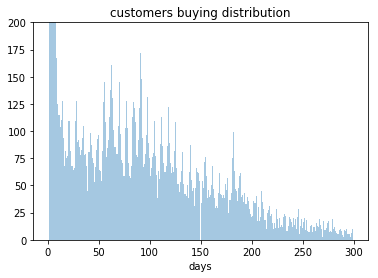

In [11]:
plt.title("customers buying distribution")
plt.xlabel("days")
plt.ylim([0,200])
sns.distplot(list(filter(lambda x: x < 300, customer_frequencies)), bins = 300, kde=False)

It's a Poisson distribution, as expected... The noise may be due to days in the week or other stationary effects

### item_code
**how many items are there?**

In [12]:
len(set(df.item_code))

2981

**how many times an item was sold?** (this may be unfair because some the new items have less chances to be there)

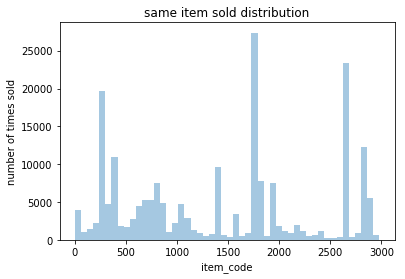

In [13]:
plt.title("same item sold distribution")
plt.xlabel("item code")
plt.ylabel("number of times sold")
# plt.ylim([0,200])
sns.distplot(df.item_code, kde=False)

### quantity
**how many items do customers usually take?**

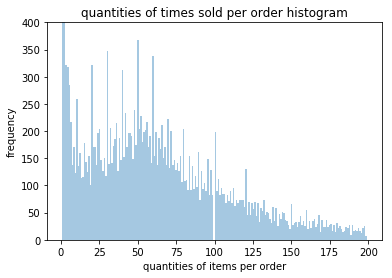

In [14]:
plt.title("quantities of times sold per order histogram")
plt.xlabel("quantities of items per order")
plt.ylabel("frequency")
plt.ylim([0,400])
sns.distplot(list(filter(lambda x: x < 200, df.groupby("order_id").quantity.sum())), bins=200, kde=False)

### sales_channel
**what is the distribution of sales channels per order?**

first, we are going to make sure that every order is acquired by the same channel...

In [15]:
np.where(df.groupby("order_id").sales_channel.min() != df.groupby("order_id").sales_channel.max())

(array([ 1999,  2000,  2001,  8403,  8404,  8406,  8408,  8411,  8474,
        21835]),)

Certain orders are not performed through the same sales channel... This may make sense, we may purchase some products online and then add some others by phone for instance. So, let's see the distribution of sales channels in per items sold instead

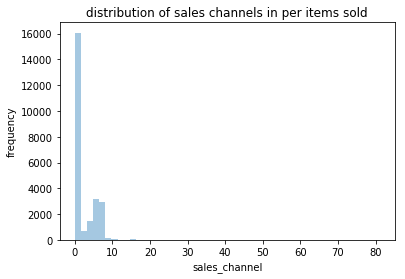

In [16]:
plt.title("distribution of sales channels in per items sold")
plt.xlabel("sales channel")
plt.ylabel("frequency")
sns.distplot(df.groupby(["order_id"]).sales_channel.min(), kde=False)

In [17]:
list(set(df.sales_channel)) == list(range(df.sales_channel.max() + 1))

True

all sales channels have been used at least once... let's redraw the previous distribution for the most frequent channels

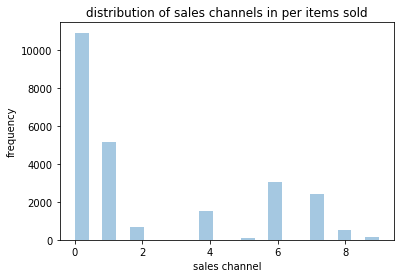

In [18]:
plt.title("distribution of sales channels in per items sold")
plt.xlabel("sales channel")
plt.ylabel("frequency")
sns.distplot(list(filter(lambda x: x<10, df.groupby(["order_id"]).sales_channel.min())), kde=False)

### total_price
**how much do customers spend per order?**

first, we see if the total_price value of the data remains the same for the entire order

In [19]:
np.where(df.groupby("order_id").total_price.min() != df.groupby("order_id").total_price.max())

(array([], dtype=int64),)

Good, data is not corrupted in that way

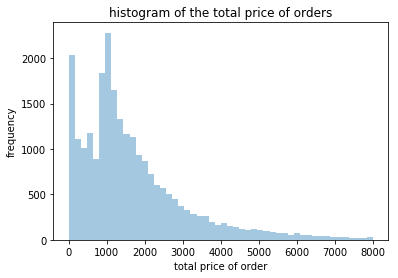

In [20]:
plt.title("histogram of the total price of orders")
plt.xlabel("total price of order")
plt.ylabel("frequency")
sns.distplot(list(filter(lambda x: x<8000, df.groupby(["order_id"]).total_price.min())), kde=False)

**how much money is earned per day?**

In [21]:
prices_df = df.groupby([df.index, "order_id"]).total_price.min()

In [22]:
prices_df.head()

register_date  order_id
2008-01-04     0            710.79
2008-01-05     1            341.65
2008-01-07     2           3035.75
               3            831.24
               4           1006.41
Name: total_price, dtype: float64

In [23]:
prices_df = prices_df.reset_index().groupby("register_date").total_price.sum()

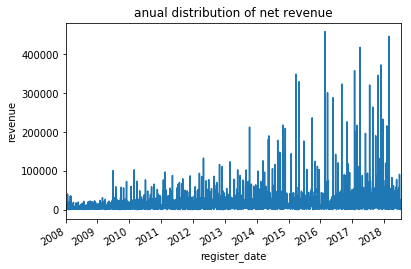

In [24]:
plt.title("anual distribution of net revenue")
plt.xlabel("date")
plt.ylabel("revenue")
prices_df.plot()

We can see what happens per year

In [25]:
prices_df = pd.DataFrame(prices_df)

In [26]:
prices_df["doy"] , prices_df["year"] = prices_df.index.dayofyear, prices_df.index.year

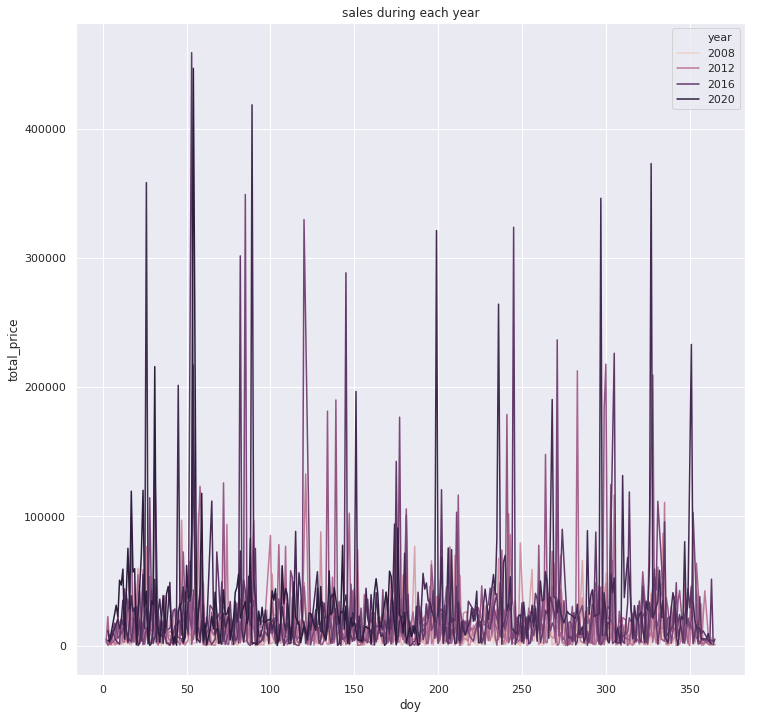

In [27]:
sns.set(rc={"figure.figsize":(12,12)})
plt.title("sales during each year")
plt.xlabel("day of year")
sns.lineplot("doy", "total_price", hue="year", data=prices_df, markers="None")

That was a bad idea... it's too noisy. let's see the average per month

In [28]:
prices_df

,total_price,doy,year
register_date,,,
2008-01-04,710.79,4,2008
2008-01-05,341.65,5,2008
2008-01-07,7165.84,7,2008
2008-01-08,969.02,8,2008
2008-01-09,6223.10,9,2008
2008-01-10,8208.07,10,2008
2008-01-11,13794.21,11,2008
2008-01-14,1171.33,14,2008
2008-01-15,6099.31,15,2008


In [29]:
prices_df["month"] = prices_df.index.month

In [30]:
prices_df = prices_df.groupby([prices_df.year, prices_df.month]).total_price.sum()

In [31]:
prices_df = prices_df.reset_index()

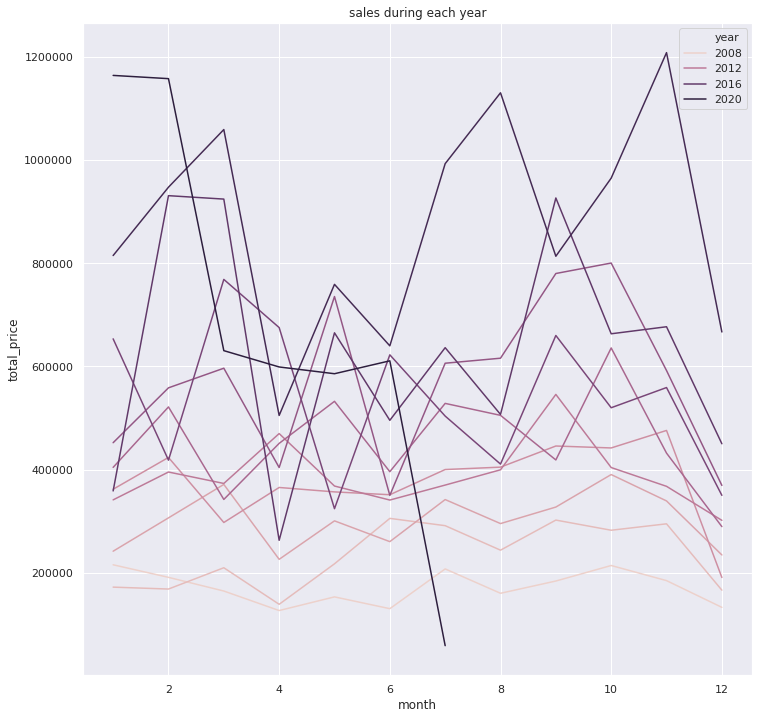

In [32]:
sns.set(rc={"figure.figsize":(12,12)})
plt.title("sales during each year")
plt.xlabel("month")
sns.lineplot("month", "total_price", hue="year", data=prices_df, markers="None")

We see that the revenue per year have increased, but this is not the usual way revenue looks. In general, these series are seasonal and the "shape" of each subplot should look similar between years... Because of that, forecasting revenue seems to be hard to do it for this dataset

### is_churn
**how accurate is this label?**

In [33]:
churn_filtered = df[df.is_churn.notna()]

In [34]:
len(df), len(churn_filtered)

(204428, 202513)

In [35]:
training_data = churn_filtered[:"2016"]

In [36]:
churn_filtered = churn_filtered[["customer_code", "is_churn"]]

In [37]:
churns = churn_filtered.groupby(["register_date", "customer_code"]).max().reset_index().sort_values(["customer_code", "register_date"])

In [38]:
churns[churns.customer_code == 836]

,register_date,customer_code,is_churn
5417,2011-07-21,836,1.0
5496,2011-08-04,836,1.0
5594,2011-08-19,836,1.0
6426,2012-01-24,836,1.0
6573,2012-02-17,836,1.0
6692,2012-03-08,836,1.0
6922,2012-04-24,836,1.0
7062,2012-05-19,836,1.0
7165,2012-06-05,836,1.0
7186,2012-06-11,836,1.0


*is_churn* seems to be constant per customer... Let's see if it's the case

In [39]:
churn_means = churns.groupby("customer_code").is_churn.mean()

In [40]:
churn_means[churn_means != 0][churn_means != 1]

Series([], Name: is_churn, dtype: float64)

correct, the *is_churn* field seems to be meaningless to me. If a customer is supposed to be a churn, and after that classification he has placed many orders, his is_churn label should be changed to False, right?

### Correlation of variables

Let us take a look at the correlation matrix to see how pairs of variables are correlated... We remove the variables that don't add information

In [41]:
corr = df.drop(columns=["is_churn", "order_id", "customer_code"]).corr()

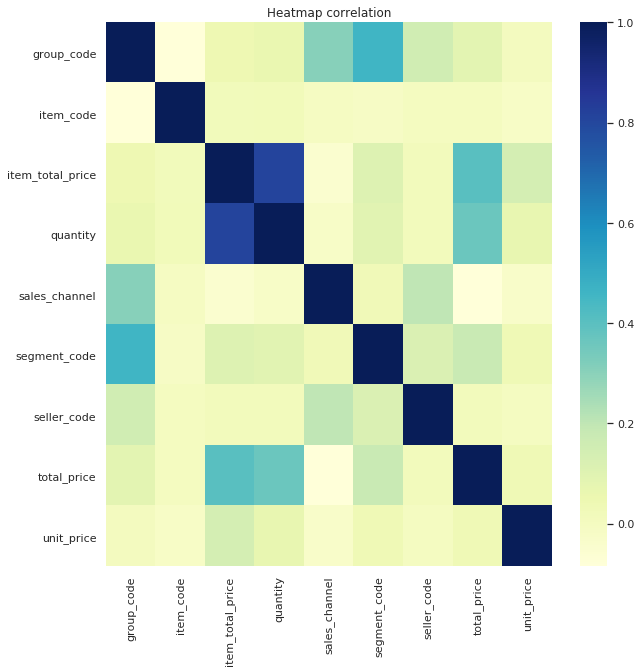

In [42]:
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap="YlGnBu") 
sns.set(font_scale=1,style="white")
plt.title("Heatmap correlation")
plt.show()

We see some logical correlations: the *item_total_price* and *the quantity*; the *group_code* and the *segment_code*. The correlation graph makes; there is no peculiar relationship

### Summary

* forecasting revenue could be a hard task: the anual comparison doesn't show seasonality
* *is_churn* is constant per customer
* the correlation matrix is as expected

### What's next?

I was thinking about forecasting monthly sales, but based on the displayed graphs, forecasting seems to be a hard task. As I have never done churn analysis, I will proceed with that. Therefore, I'll save the *customer_frequencies* variable

In [43]:
import pickle

In [44]:
with open("../models/customer_frequencies.pkl", "wb") as fd:
    pickle.dump(customer_frequencies, fd)